In [1]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
#|hide
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
#|default_exp agents.dqn.basic

In [4]:
#|export
# Python native modules
import os
from collections import deque
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch.utils.data.dataloader_experimental import DataLoader2
from torch.utils.data.datapipes._typing import _DataPipeMeta, _IterDataPipeMeta
# Local modules
import torch
from torch.nn import *
import torch.nn.functional as F
from torch.optim import *
from fastai.torch_basics import *
from fastai.torch_core import *

from fastrl.core import *
from fastrl.agents.core import *
from fastrl.pipes.core import *
from fastrl.fastai.data.block import *
from fastrl.memory.experience_replay import *
from fastrl.agents.core import *
from fastrl.agents.discrete import *
from fastrl.loggers.core import *
from fastrl.loggers.jupyter_visualizers import *
from fastrl.learner.core import *
from fastrl.agents.dqn.basic import *

# DQN Target
> DQN that uses snapshots from the NN module to stabilize training



## Training DataPipes

In [15]:
#|export
class TargetQCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,discount=0.99,nsteps=1,target_sync=300):
        self.source_datapipe = source_datapipe
        self.discount = discount
        self.nsteps = nsteps
        self.learner = find_pipe_instance(self,LearnerBase)
        self.learner.target_model=deepcopy(self.learner.model)
        self.target_sync = target_sync
        self.n_batch = 0
                
    def __iter__(self):
        for batch in self.source_datapipe:
            try:
                self.learner.done_mask = batch.terminated.reshape(-1,)
                with torch.no_grad():
                    self.learner.next_q = self.learner.target_model(batch.next_state)
                self.learner.next_q = self.learner.next_q.max(dim=1).values.reshape(-1,1)
                self.learner.next_q[self.learner.done_mask] = 0 #xb[done_mask]['reward']
                self.learner.targets = batch.reward+self.learner.next_q*(self.discount**self.nsteps)
                self.learner.pred = self.learner.model(batch.state)

                t_q=self.learner.pred.clone()
                t_q.scatter_(1,batch.action.long(),self.learner.targets)

                self.learner.loss_grad = self.learner.loss_func(self.learner.pred, t_q)
                
                if self.n_batch%self.target_sync==0:
                    self.learner.target_model.load_state_dict(self.learner.model.state_dict())
                self.n_batch+=1
                
                yield batch
            except RuntimeError as e:
                print(f'Failed on batch: {batch}')
                raise

In [16]:
#|export
def DQNLearner(
    model,
    dls,
    logger_bases=None,
    loss_func=MSELoss(),
    opt=AdamW,
    lr=0.005,
    bs=128,
    max_sz=10000,
    nsteps=1
) -> LearnerHead:
    learner = LearnerBase(model,dls,loss_func=MSELoss(),opt=opt(model.parameters(),lr=lr))
    learner = BatchCollector(learner,logger_bases=logger_bases,batch_on_pipe=LearnerBase)
    learner = EpocherCollector(learner,logger_bases=logger_bases)
    for logger_base in logger_bases: learner = logger_base.connect_source_datapipe(learner)
    learner = RollingTerminatedRewardCollector(learner,logger_bases)
    learner = EpisodeCollector(learner,logger_bases)
    learner = ExperienceReplay(learner,bs=bs,max_sz=max_sz)
    learner = StepBatcher(learner)
    learner = TargetQCalc(learner,nsteps=nsteps)
    learner = ModelLearnCalc(learner)
    learner = LossCollector(learner,logger_bases)
    learner = LearnerHead(learner)
    return learner

Try training with basic defaults...

In [17]:
from fastrl.envs.gym import *
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=4000)
# Setup the DataBlock
block = DataBlock(
    blocks = GymTransformBlock(agent=agent,nsteps=1,nskips=1,firstlast=False)
)
# pipes = L(block.datapipes(['CartPole-v1']*1,n=10))
dls = L(block.dataloaders(['CartPole-v1']*1,n=1000,bs=1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,max_sz=100_000)
# learner.fit(3)
learner.fit(25)

loss,episode,rolling_reward,epoch,batch,epsilon
0.015635563,45,22.613636,1,999,0.749500
0.02806328,85,23.547619,2,999,0.499250
0.05995224,105,28.59,3,999,0.249000
0.032530487,112,36.27,4,999,0.020000
0.16022108,114,46.93,5,999,0.020000
0.13971642,119,54.51,6,999,0.020000
0.61972004,125,63.34,7,999,0.020000
0.16388969,128,72.52,8,999,0.020000
0.44052687,132,81.75,9,999,0.020000
0.3196777,135,88.99,10,999,0.020000


The DQN learners, but I wonder if we can get it to learn faster...

In [18]:
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=10000)
# Setup the DataBlock
block = DataBlock(
    blocks = GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True) # We basically merge 2 steps into 1 and skip. 
)
# pipes = L(block.datapipes(['CartPole-v1']*1,n=10))
dls = L(block.dataloaders(['CartPole-v1']*1,n=1000,bs=1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,max_sz=20_000,nsteps=2,lr=0.001)
# learner.fit(3)
learner.fit(10)

loss,episode,rolling_reward,epoch,batch,epsilon
0.16424617,79,24.28,1,999,0.811000
1.3833876,124,41.06,2,999,0.617400
1.8638965,145,68.02,3,999,0.420200
3.1018682,155,104.12,4,999,0.221100
5.1498814,164,135.7,5,999,0.022100
5.4767675,171,161.26,6,999,0.020000
5.9049835,178,187.54,7,999,0.020000
2.703928,185,221.16,8,999,0.020000
9.12526,191,243.38,9,999,0.020000


KeyboardInterrupt: 

In [19]:
from fastrl.loggers.jupyter_visualizers import *

In [20]:
model.eval()

DQN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [21]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.envs.gym import GymTypeTransform,GymStepper

def gym_pipe_base(envs,total_steps,seed=0):
    pipe = dp.map.Mapper(envs)
    pipe = TypeTransformLoop(pipe,[GymTypeTransform])
    pipe = dp.iter.MapToIterConverter(pipe)
    pipe = dp.iter.InMemoryCacheHolder(pipe)
    pipe = pipe.cycle(count=total_steps)
    pipe = GymStepper(pipe,agent=agent,seed=seed,include_images=True)
    return pipe

In [22]:
%matplotlib inline

KeyboardInterrupt: 

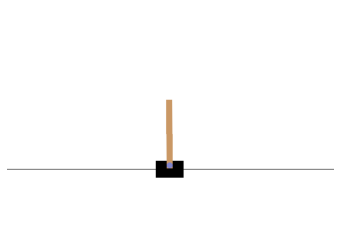

In [24]:

video_logger = SimpleJupyterVideoPlayer()

pipe = gym_pipe_base(['CartPole-v1'],1000,seed=None)
pipe = ImageCollector(pipe,[video_logger])

pipe = video_logger.connect_source_datapipe(pipe)

for o in pipe:pass

In [ ]:
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(8,4)
# Setup the Agent
agent = DQNAgent(model,[logger_base])
# Setup the DataBlock
block = DataBlock(
    blocks = GymTransformBlock(agent=agent)
)
dls = L(block.dataloaders(['LunarLander-v2']*1,n=1000,bs=1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base])
learner.fit(3)
# learner.fit(30)

In [ ]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.envs.gym import GymTypeTransform,GymStepper

def gym_pipe_base(envs,total_steps,seed=0):
    pipe = dp.map.Mapper(envs)
    pipe = TypeTransformLoop(pipe,[GymTypeTransform])
    pipe = dp.iter.MapToIterConverter(pipe)
    pipe = dp.iter.InMemoryCacheHolder(pipe)
    pipe = pipe.cycle(count=total_steps)
    pipe = GymStepper(pipe,agent=agent,seed=seed,include_images=True)
    return pipe

In [ ]:

video_logger = SimpleJupyterVideoPlayer()

pipe = gym_pipe_base(['LunarLander-v2'],1000,seed=None)
pipe = ImageCollector(pipe,[video_logger])

pipe = video_logger.connect_source_datapipe(pipe)

L(pipe);

In [ ]:
#|hide
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()